# 1. Imports

In [ ]:
import os
import warnings
import random
import sys
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import (
    ConfusionMatrixDisplay, 
    classification_report, 
    accuracy_score, 
    confusion_matrix,
    f1_score
)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from transformers import logging

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from utils import clean_text, set_seed, setup_notebook_logging
from data import load_data, preprocess_data, encode_labels, split_data
from tokenization import get_max_length
from custom_datasets import LanguageDataset, create_datasets

from training import evaluate_latency
from visualization import (
    plot_target_structure,
    display_encodings_info,
    plot_training_history,
    plot_msp_calibration,
    plot_top5_calibration,
    compute_ece,
    plot_ece_bar,
    plot_embeddings,
    plot_confidence_distribution,
    plot_roc_curve
)
from interpretability import (
    get_embeddings,
    get_logits,
    analyze_mixed_language_offset,
    print_analysis,
    visualize_attention,
    visualize_bert_attention,
    run_standard_case_study,
    run_hard_case_study,
    get_error_cases,
    get_confused_pairs,
    visualize_top_confused_pairs
)
from ood_utils import (
    create_ood_dataset_df, 
    calculate_ood_metrics
)

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

logging.set_verbosity_error()

# Check versions
!python --version
libs = [np, pd, torch]
for lib in libs:
    print(f"{lib.__name__} version: {lib.__version__}")

# Setup logging and figure saving
setup_notebook_logging("/home/zyk/Language Identification/outputs")

Python 3.10.17
numpy version: 1.23.5
pandas version: 1.5.3
torch version: 2.6.0+cu124
Figures will be saved to: /home/zyk/Language Identification/outputs/figures/distilbert
Logs will be saved to: /home/zyk/Language Identification/outputs/logs/distilbert
plt.show has been patched to save figures automatically.
Stdout redirected to /home/zyk/Language Identification/outputs/logs/distilbert/notebook_output.log
numpy version: 1.23.5
pandas version: 1.5.3
torch version: 2.6.0+cu124
Figures will be saved to: /home/zyk/Language Identification/outputs/figures/distilbert
Logs will be saved to: /home/zyk/Language Identification/outputs/logs/distilbert
plt.show has been patched to save figures automatically.
Stdout redirected to /home/zyk/Language Identification/outputs/logs/distilbert/notebook_output.log


In [ ]:
from config import (
    DATA_DIR,
    MODEL_NAME,
    RANDOM_STATE,
    BATCH_SIZE,
    DEVICE,
    NUM_EPOCHS,
    NUM_WORKERS
)
# NUM_LABELS will be determined dynamically

set_seed(RANDOM_STATE)

Random seed set as 42


# 2. Dataset

## 2.1 Load and Preprocess

In [3]:
lang_data = load_data(DATA_DIR)
display(lang_data.sample(n=15, random_state=RANDOM_STATE))

df_filtered = preprocess_data(lang_data)
texts_data = df_filtered["Text"]
labels_data = df_filtered["language"]

NUM_LABELS = len(labels_data.unique())
print(f"Total number of languages: {NUM_LABELS}")

,Text,language
13035,武器システムにおいては、上述の通り、アスロック対潜ミサイルのmk gmls（mk 連装発射機...,Japanese
3115,в апреле года ломоносов за дерзкое поведение ...,Russian
8732,bagnizeau est commune francicum incolarum ann...,Latin
7591,قاسم اباد د ننگرهار ولایت د بهسودو ولسوالۍ له ...,Pushto
221,सार्क कॉन्सोर्टियम ऑन ओपन एंड डिस्टेंस लर्निंग...,Hindi
17295,relatório da repartição dos negócios da fazend...,Portugese
5857,كان مستغرباً أن يتحدث مراد بك بهذه الثقة الزائ...,Arabic
12608,وسعت عرصهٔ شهری کرمانشاه برابر با ٫ کیلومتر مر...,Persian
3463,भारत में दशमलव प्रणाली हड़प्पाकाल में अस्तित्व...,Hindi
6478,авто́бусный переу́лок — переулок в городе влад...,Russian


Total number of languages: 22


In [4]:
df_filtered.info()
print(df_filtered.index)
print(labels_data.value_counts())

display(df_filtered.sample(frac=0.001, random_state=RANDOM_STATE))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      22000 non-null  object
 1   language  22000 non-null  object
dtypes: object(2)
memory usage: 343.9+ KB
RangeIndex(start=0, stop=22000, step=1)
Estonian      1000
Swedish       1000
English       1000
Russian       1000
Romanian      1000
Persian       1000
Pushto        1000
Spanish       1000
Hindi         1000
Korean        1000
Chinese       1000
French        1000
Portugese     1000
Indonesian    1000
Urdu          1000
Latin         1000
Turkish       1000
Japanese      1000
Dutch         1000
Tamil         1000
Thai          1000
Arabic        1000
Name: language, dtype: int64


,Text,language
13035,武器システムにおいては、上述の通り、アスロック対潜ミサイルのmk gmls（mk 連装発射機...,Japanese
3115,в апреле года ломоносов за дерзкое поведение п...,Russian
8732,bagnizeau est commune francicum incolarum anno...,Latin
7591,قاسم اباد د ننگرهار ولایت د بهسودو ولسوالۍ له ...,Pushto
221,सार्क कॉन्सोर्टियम ऑन ओपन एंड डिस्टेंस लर्निंग...,Hindi
17295,relatório da repartição dos negócios da fazend...,Portugese
5857,كان مستغرباً أن يتحدث مراد بك بهذه الثقة الزائ...,Arabic
12608,وسعت عرصهٔ شهری کرمانشاه برابر با ٫ کیلومتر مر...,Persian
3463,भारत में दशमलव प्रणाली हड़प्पाकाल में अस्तित्व...,Hindi
6478,авто́бусный переу́лок — переулок в городе влад...,Russian


Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Shares_of_objects_in_each_language_class.png


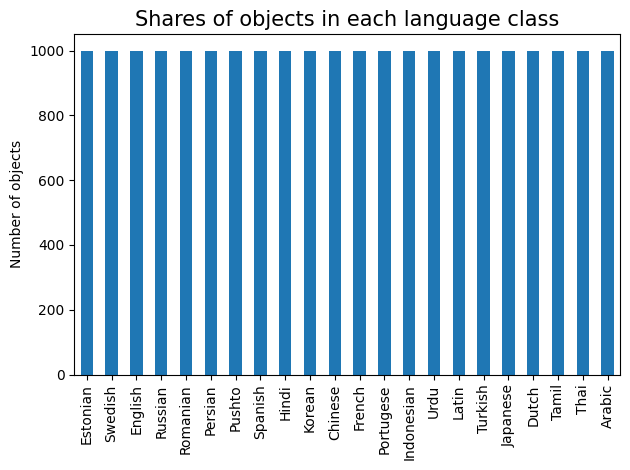

In [5]:
# Plotting the structure of the target variable
lang_counts = df_filtered["language"].value_counts()
lang_counts.plot(kind="bar")
plt.title("Shares of objects in each language class", fontsize=15)
plt.ylabel("Number of objects")
plt.tight_layout()
plt.show()

## 2.2 Encoding Labels

In [6]:
# Encoding the labels
texts_data, labels_data_encoded, class_label = encode_labels(df_filtered)
class_names = class_label.names

# Displaying the encoding results
for idx, class_name in enumerate(class_names):
    print(f"{idx} => {class_name}")

# Separating data into training set and validation/test sets
(
    training_texts, 
    validation_texts, 
    testing_texts, 
    training_labels, 
    validation_labels, 
    testing_labels
) = split_data(texts_data, labels_data_encoded, random_state=RANDOM_STATE)

print(f"Training shape: {training_texts.shape[0]}")
print(f"Validation shape: {validation_texts.shape[0]}")
print(f"Testing shape: {testing_texts.shape[0]}")

0 => Arabic
1 => Chinese
2 => Dutch
3 => English
4 => Estonian
5 => French
6 => Hindi
7 => Indonesian
8 => Japanese
9 => Korean
10 => Latin
11 => Persian
12 => Portugese
13 => Pushto
14 => Romanian
15 => Russian
16 => Spanish
17 => Swedish
18 => Tamil
19 => Thai
20 => Turkish
21 => Urdu
Training shape: 17600
Validation shape: 2200
Testing shape: 2200


Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Full_data_set.png


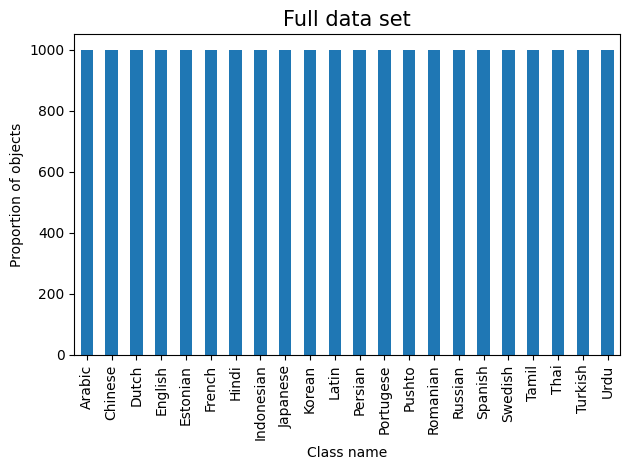

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Training_set.png


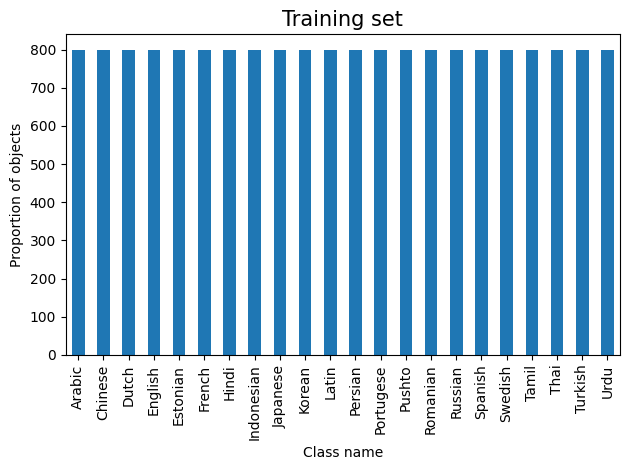

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Validation_set.png


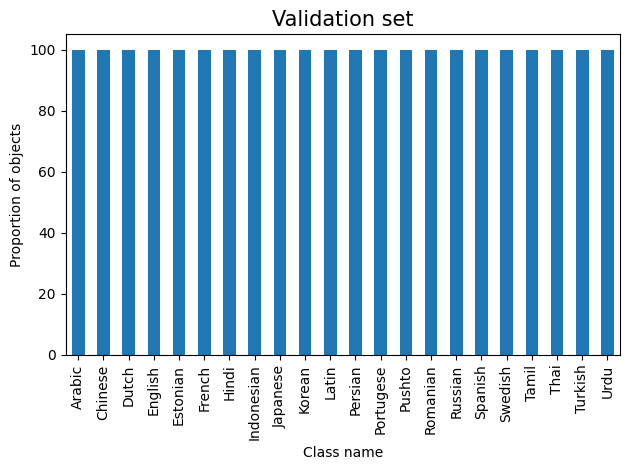

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Test_set.png


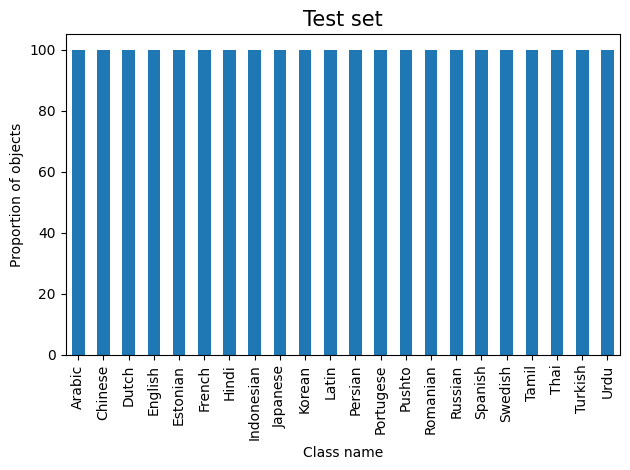

In [7]:
plot_target_structure(
    labels=labels_data_encoded,
    class_label=class_label,
    fig_title="Full data set"
)

plot_target_structure(
    labels=training_labels,
    class_label=class_label,
    fig_title="Training set"
)

plot_target_structure(
    labels=validation_labels,
    class_label=class_label,
    fig_title="Validation set"
)

plot_target_structure(
    labels=testing_labels,
    class_label=class_label,
    fig_title="Test set"
)

## 2.3 Tokenization

In [ ]:
# Instantiating the classifier wrapper
from models.distilbert_model import DistilBertClassifier
classifier = DistilBertClassifier(MODEL_NAME, DEVICE)
distilbert_tokenizer = classifier.tokenizer

print(f"sample text: {training_texts[90]}")
tokens = distilbert_tokenizer(training_texts[90])
print(f"encoded text: {tokens}")
print(f"decoded text: {distilbert_tokenizer.decode(tokens['input_ids'])}")

/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


sample text: nordahl road is a station served by north county transit districts sprinter light rail line it straddles the city limits of san marcos and escondido california with its mailing address in escondido the station is located between barham drive and auto park waynordahl road both of which intersect east mission road it consists of a single platform and track
encoded text: {'input_ids': [101, 11308, 78975, 15485, 10124, 169, 11825, 12325, 10155, 12756, 17382, 60486, 24412, 42707, 10165, 15765, 29547, 12117, 10271, 17791, 11488, 92503, 10105, 11584, 47418, 10108, 14608, 52872, 10107, 10111, 10196, 23486, 38482, 25923, 13918, 26302, 10280, 10169, 10474, 30049, 10230, 32198, 10106, 10196, 23486, 38482, 10105, 11825, 10124, 11954, 10948, 18121, 13196, 23806, 10111, 18257, 14900, 13170, 36064, 101036, 15485, 11408, 10108, 10319, 22021, 104380, 13827, 17032, 15485, 10271, 20963, 10108, 169, 11376, 22753, 10111, 14310, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

## 2.4 Optimal Length Calculation

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/figure_1.png


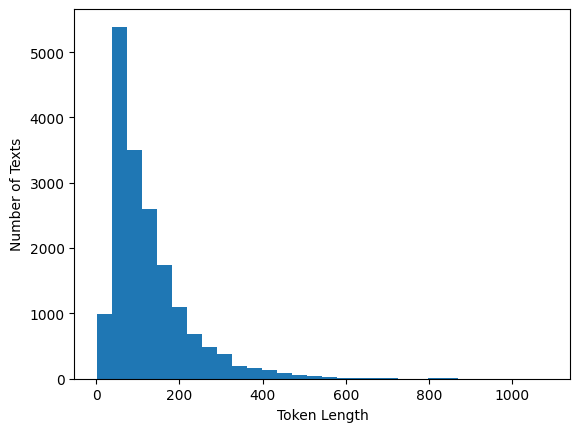

Suggested max_length: 310


In [9]:
lengths = [len(distilbert_tokenizer.encode(text)) for text in training_texts]
plt.hist(lengths, bins=30)
plt.xlabel('Token Length')
plt.ylabel('Number of Texts')
plt.show()

# Calculate the 95th percentile
max_length = get_max_length(distilbert_tokenizer, training_texts)

print(f"Suggested max_length: {max_length}")

## 2.5 Create Datasets

In [10]:
# Tokenizing and creating datasets
training_dataset, validation_dataset, testing_dataset, _ = create_datasets(
    training_texts, validation_texts, testing_texts, 
    training_labels, validation_labels, testing_labels, 
    distilbert_tokenizer, max_length=max_length
)

# Extract encodings for visualization/compatibility
training_encodings = training_dataset.encodings
validation_encodings = validation_dataset.encodings
testing_encodings = testing_dataset.encodings

In [11]:
display_encodings_info(
    tokenizer=distilbert_tokenizer,
    encodings=training_encodings, 
    texts=training_texts, 
    labels=training_labels,
    text_idx=10,
    class_label=class_label,
)


Original Text: messaoudi debuteerde bij sparta en speelde vervolgens bij hfc haarlem in het seizoen probeerde hij aan de slag te gaan in het britse voetbal hij was op proef bij chelsea fc fulham fc southampton fc peterborough united en het schotse falkirk fc daar tekende hij in oktober tot het einde van het kalenderjaar na nog een proefperiode bij wycombe wanderers ging hij in het amateurvoetbal spelen in het seizoen speelde hij nog in belgië waar hij woonachtig was voor kfc wuustwezel hij geeft training in het amateurvoetbal
Encoded Tokens: [101, 64288, 50555, 10116, 82832, 11296, 32650, 51119, 10110, 19977, 36755, 11296, 176, 10575, 10350, 12735, 19343, 10106, 10187, 18117, 110239, 15676, 10785, 10727, 10104, 32072, 10361, 21681, 10106, 10187, 52676, 10341, 61750, 10785, 10134, 10303, 11284, 16822, 11296, 10262, 14433, 10113, 174, 10350, 11005, 42182, 10147, 174, 10350, 13144, 53692, 11183, 174, 10350, 32784, 10165, 33057, 89284, 10110, 10187, 104016, 45507, 12211, 41910, 16299, 174,

# 3. Model Definition & Training

## 3.1 Label Mapping

In [12]:
# Creating a mapping from predictions to label names
id2label_mappings = dict()
for i, name in enumerate(class_names):
    id2label_mappings[i] = name
id2label_mappings

{0: 'Arabic',
 1: 'Chinese',
 2: 'Dutch',
 3: 'English',
 4: 'Estonian',
 5: 'French',
 6: 'Hindi',
 7: 'Indonesian',
 8: 'Japanese',
 9: 'Korean',
 10: 'Latin',
 11: 'Persian',
 12: 'Portugese',
 13: 'Pushto',
 14: 'Romanian',
 15: 'Russian',
 16: 'Spanish',
 17: 'Swedish',
 18: 'Tamil',
 19: 'Thai',
 20: 'Turkish',
 21: 'Urdu'}

## 3.2 Instantiate Model

In [13]:
# Computing the number of classes
NUM_LABELS = len(class_names)

# Building the model within the classifier wrapper
classifier.build_model(num_labels=NUM_LABELS, id2label_mappings=id2label_mappings)
distilbert_model = classifier.model

/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/accelerate/accelerator.py:479: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


{'loss': 2.027, 'grad_norm': 2.136273145675659, 'learning_rate': 9.090909090909091e-06, 'epoch': 0.36}
{'loss': 0.665, 'grad_norm': 1.765685796737671, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.73}
{'loss': 0.665, 'grad_norm': 1.765685796737671, 'learning_rate': 1.8181818181818182e-05, 'epoch': 0.73}
{'eval_loss': 0.645794689655304, 'eval_accuracy': 0.9904545454545455, 'eval_f1': 0.9905505087460518, 'eval_precision': 0.9909561993788288, 'eval_recall': 0.9904545454545455, 'eval_runtime': 1.7768, 'eval_samples_per_second': 1238.17, 'eval_steps_per_second': 19.698, 'epoch': 1.0}
{'eval_loss': 0.645794689655304, 'eval_accuracy': 0.9904545454545455, 'eval_f1': 0.9905505087460518, 'eval_precision': 0.9909561993788288, 'eval_recall': 0.9904545454545455, 'eval_runtime': 1.7768, 'eval_samples_per_second': 1238.17, 'eval_steps_per_second': 19.698, 'epoch': 1.0}
{'loss': 0.652, 'grad_norm': 0.60135418176651, 'learning_rate': 1.9919548128307954e-05, 'epoch': 1.09}
{'loss': 0.652, 'grad_no

<Figure size 1200x1000 with 0 Axes>

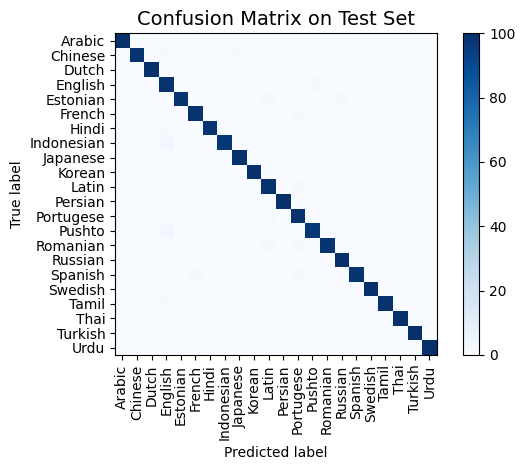

,Arabic,Chinese,Dutch,English,Estonian,French,Hindi,Indonesian,Japanese,Korean,...,Portugese,Pushto,Romanian,Russian,Spanish,Swedish,Tamil,Thai,Turkish,Urdu
Arabic,100,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Chinese,0,98,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
Dutch,0,0,100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
English,0,0,0,99,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Estonian,0,0,0,0,98,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
French,0,0,0,0,0,99,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Hindi,0,0,0,1,0,0,98,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Indonesian,0,0,0,3,0,0,0,97,0,0,...,0,0,0,0,0,0,0,0,0,0
Japanese,0,0,0,0,0,0,0,0,100,0,...,0,0,0,0,0,0,0,0,0,0
Korean,0,0,0,0,0,0,0,0,0,100,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", message="huggingface/tokenizers")

# Train the model
trainer = classifier.train(
    train_dataset=training_dataset,
    validation_dataset=validation_dataset,
    output_dir="/home/zyk/Language Identification/models/distillbert_results",
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    num_workers=NUM_WORKERS,
    random_state=RANDOM_STATE
)

# Evaluate on validation set
eval_metrics = trainer.evaluate()
print("Validation metrics:", eval_metrics)

# Save best model
trainer.save_model("/home/zyk/Language Identification/models/best_distilbert_model")

preds_output = trainer.predict(testing_dataset)

logits = preds_output.predictions
preds = np.argmax(logits, axis=1)
labels = testing_labels

# ---- Key metrics ----

acc = accuracy_score(labels, preds)
macro_f1 = f1_score(labels, preds, average="macro")

print(f"Test Accuracy: {acc:.4f}")
print(f"Macro-F1: {macro_f1:.4f}\n")

# ---- Classification report ----
print("Classification Report:")
print(classification_report(labels, preds, target_names=class_names))

# ---- Confusion Matrix (Plot) ----
cm = confusion_matrix(labels, preds)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=False, cmap="Blues", xticks_rotation=90)

plt.title("Confusion Matrix on Test Set", fontsize=14)
plt.tight_layout()
plt.show()

# ---- Confusion Matrix Table ----
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df

## 3.3 Training Dynamics Visualization

#### Loss Curves (Train vs Validation)
#### Accuracy / F1 Curves (Validation)


Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Training_Dynamics_Loss_Curves.png


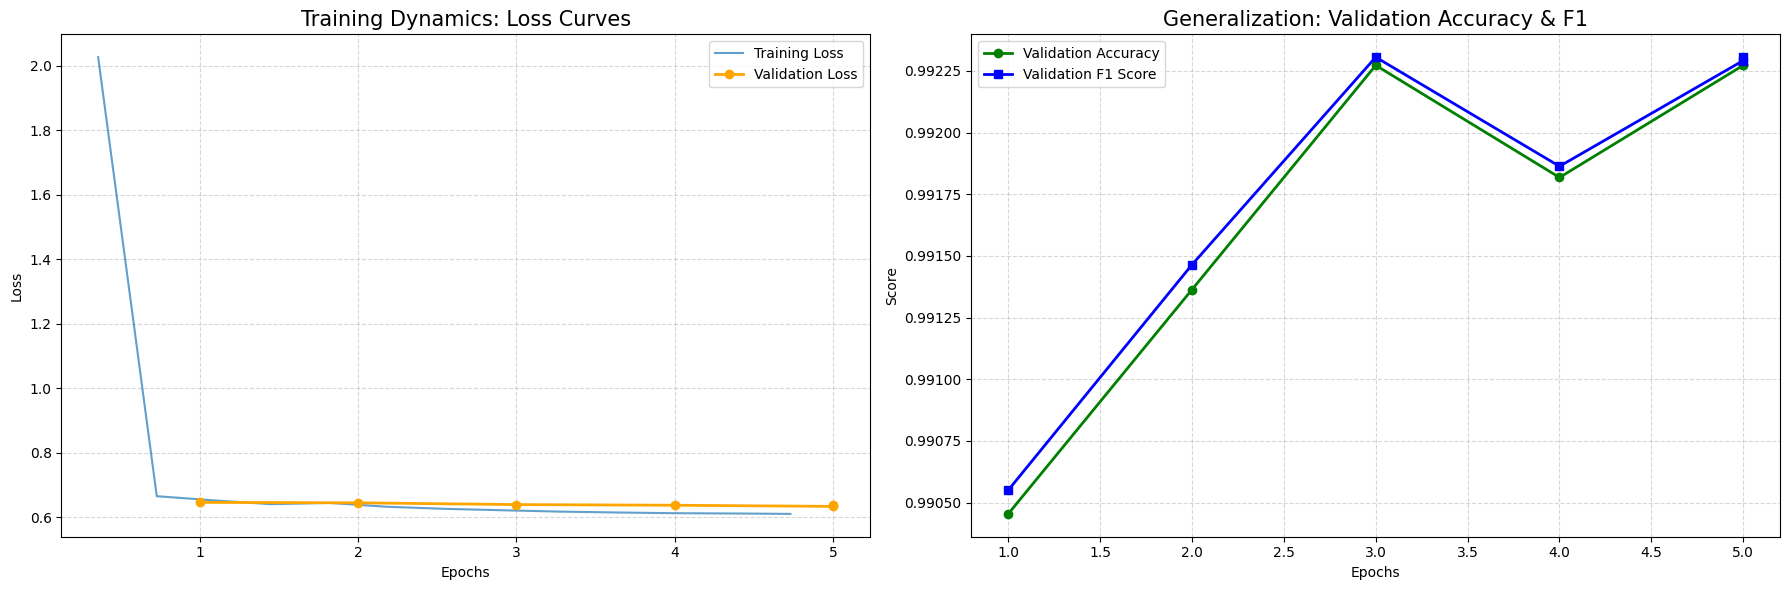

Training finished after 6 epochs.
Early stopping triggered at epoch 6 (Max epochs: 8).


In [15]:
# Extract training history from the trainer state
history = trainer.state.log_history
plot_training_history(history, NUM_EPOCHS)

=== MSP Calibration Curve ===
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/MSP_Calibration_Curve.png


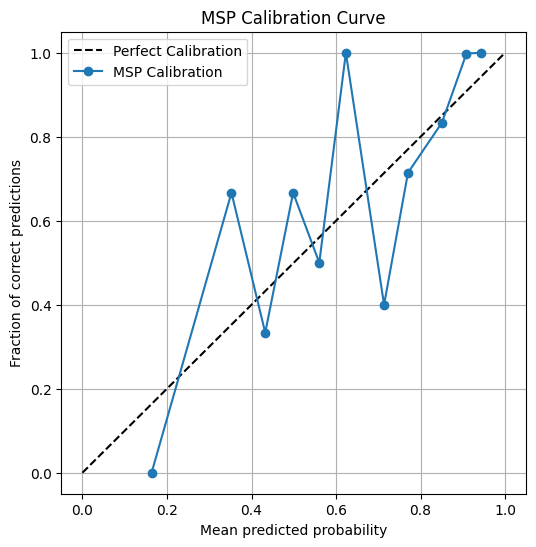

=== Top-5 Calibration Curves ===
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Top-5_Frequent_Classes_Calibration_Curves.png


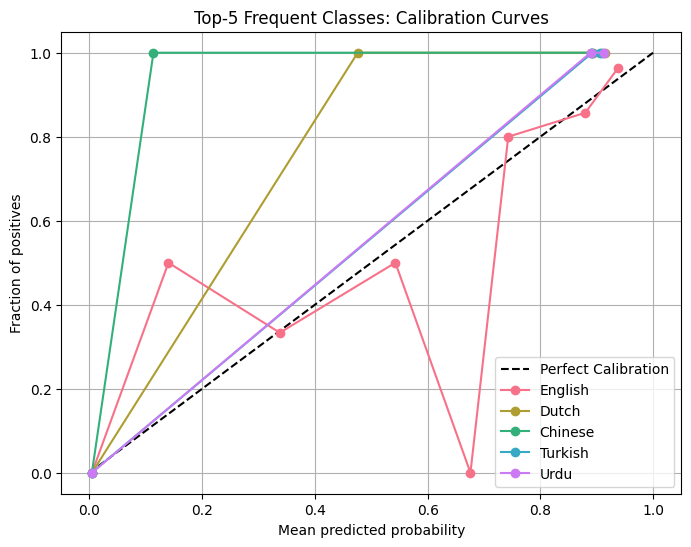

=== ECE Calculation ===
ECE = 0.0884
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/ECE_per_Confidence_Bin.png


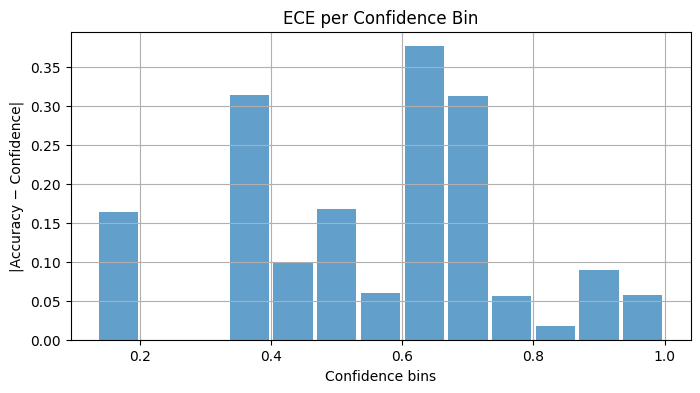

In [16]:
# Convert logits → probabilities
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
preds = np.argmax(probs, axis=1)

# =============================
# Run all plots
# =============================
print("=== MSP Calibration Curve ===")
plot_msp_calibration(probs, preds, labels)

print("=== Top-5 Calibration Curves ===")
plot_top5_calibration(probs, labels, class_names, top_k=5)

print("=== ECE Calculation ===")
ece, bins, bin_accs, bin_confs, bin_sizes = compute_ece(probs, preds, labels)
print(f"ECE = {ece:.4f}")

plot_ece_bar(bin_accs, bin_confs, bins)

## 3.4 Latency Evaluation

In [17]:
# Use real data from the test set
single_text = testing_texts.iloc[0]
batch_texts = testing_texts.iloc[:BATCH_SIZE].tolist()

# Devices to test
devices = [torch.device("cpu")]
if torch.cuda.is_available():
    devices.append(torch.device("cuda"))

print(f"{'Device':<10} | {'Type':<20} | {'Batch Size':<10} | {'Latency (ms)':<20} | {'Throughput (samples/s)':<25}")
print("-" * 95)

for device in devices:
    # Single-sample Latency
    mean, std, bs = evaluate_latency(distilbert_model, distilbert_tokenizer, [single_text], device)
    throughput = (1000 / mean) * bs
    print(f"{str(device):<10} | {'Single-sample':<20} | {bs:<10} | {mean:.2f} ± {std:.2f}        | {throughput:.2f}")
    
    # Batch Latency
    mean, std, bs = evaluate_latency(distilbert_model, distilbert_tokenizer, batch_texts, device)
    throughput = (1000 / mean) * bs
    print(f"{str(device):<10} | {'Batch':<20} | {bs:<10} | {mean:.2f} ± {std:.2f}        | {throughput:.2f}")

# Restore model to original device
distilbert_model.to(DEVICE)

Device     | Type                 | Batch Size | Latency (ms)         | Throughput (samples/s)   
-----------------------------------------------------------------------------------------------
cpu        | Single-sample        | 1          | 28.40 ± 5.50        | 35.21
cpu        | Single-sample        | 1          | 28.40 ± 5.50        | 35.21
cpu        | Batch                | 64         | 1086.82 ± 26.13        | 58.89
cpu        | Batch                | 64         | 1086.82 ± 26.13        | 58.89
cuda       | Single-sample        | 1          | 5.25 ± 0.03        | 190.43
cuda       | Single-sample        | 1          | 5.25 ± 0.03        | 190.43
cuda       | Batch                | 64         | 9.18 ± 0.01        | 6968.90
cuda       | Batch                | 64         | 9.18 ± 0.01        | 6968.90


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


#  4 Model Internal Structure Visualization

This section visualizes the internal representations (embeddings) learned by the model.
I extract the CLS token embeddings for the test set and project them into 2D space using PCA and t-SNE.
This demonstrates:
- The geometric structure of language families.
- Clustering of character patterns.
- Natural distances between categories.

Extracting embeddings from the test set...


Extracting embeddings: 100%|██████████| 69/69 [00:01<00:00, 44.92it/s]


Applying PCA...
Applying t-SNE...
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Embedding_Clusters_Visualization_(PCA)_Geometric_Structure_of_Languages.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Embedding_Clusters_Visualization_(PCA)_Geometric_Structure_of_Languages.png


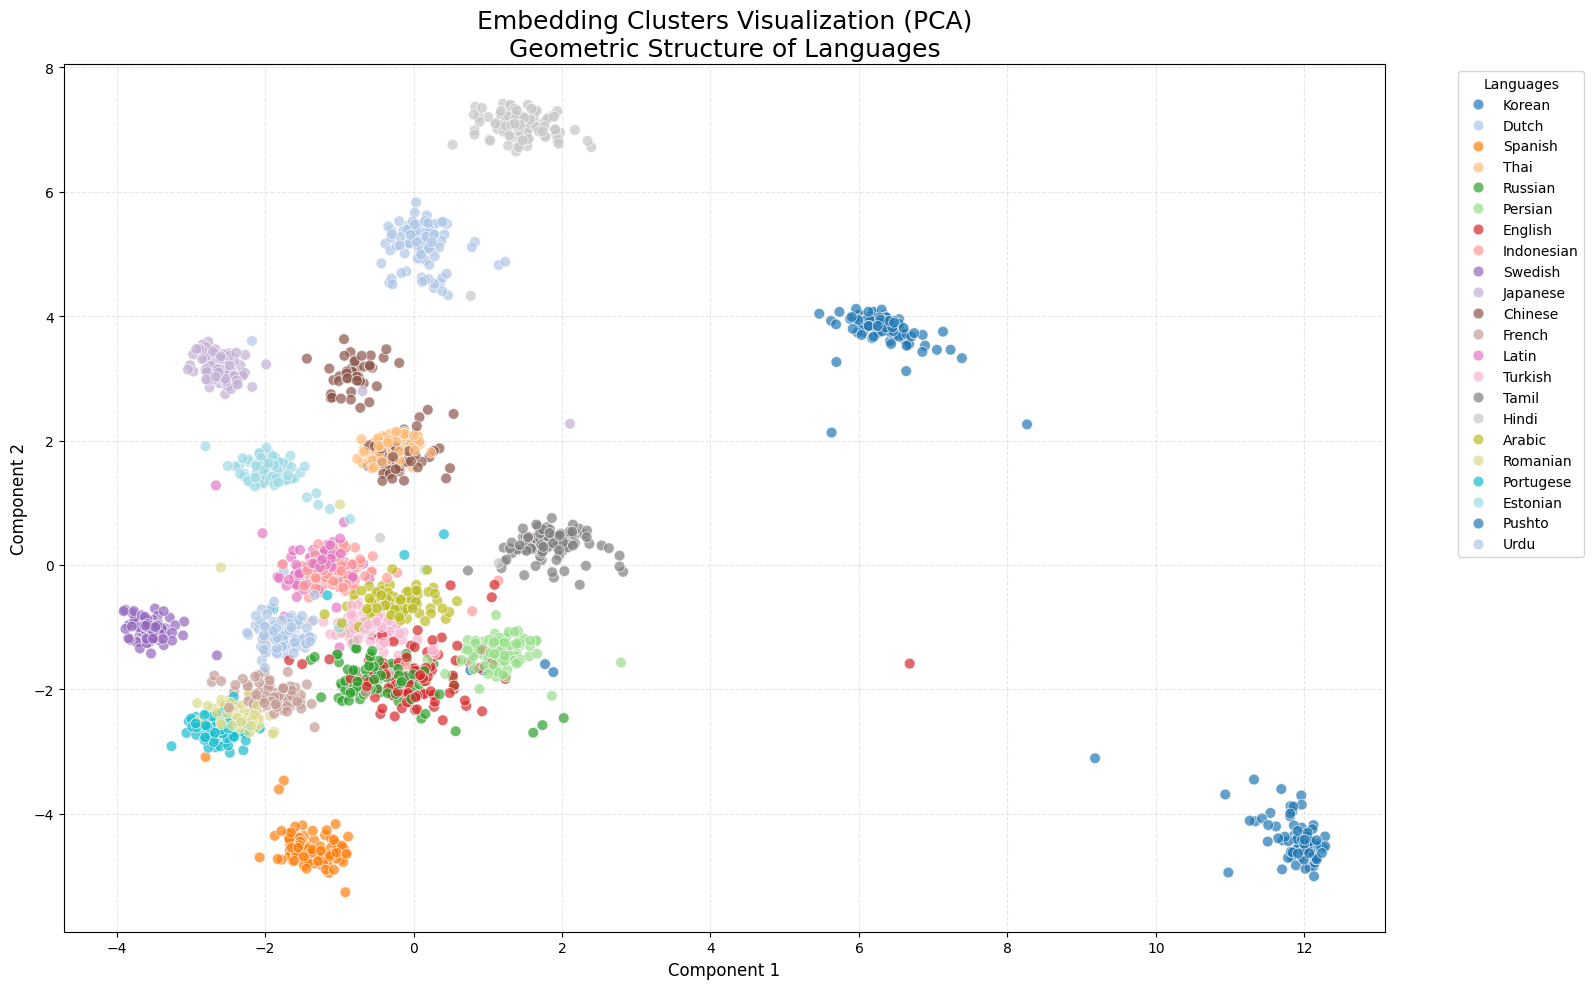

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Embedding_Clusters_Visualization_(t-SNE)_Natural_Distances_between_Categories.png


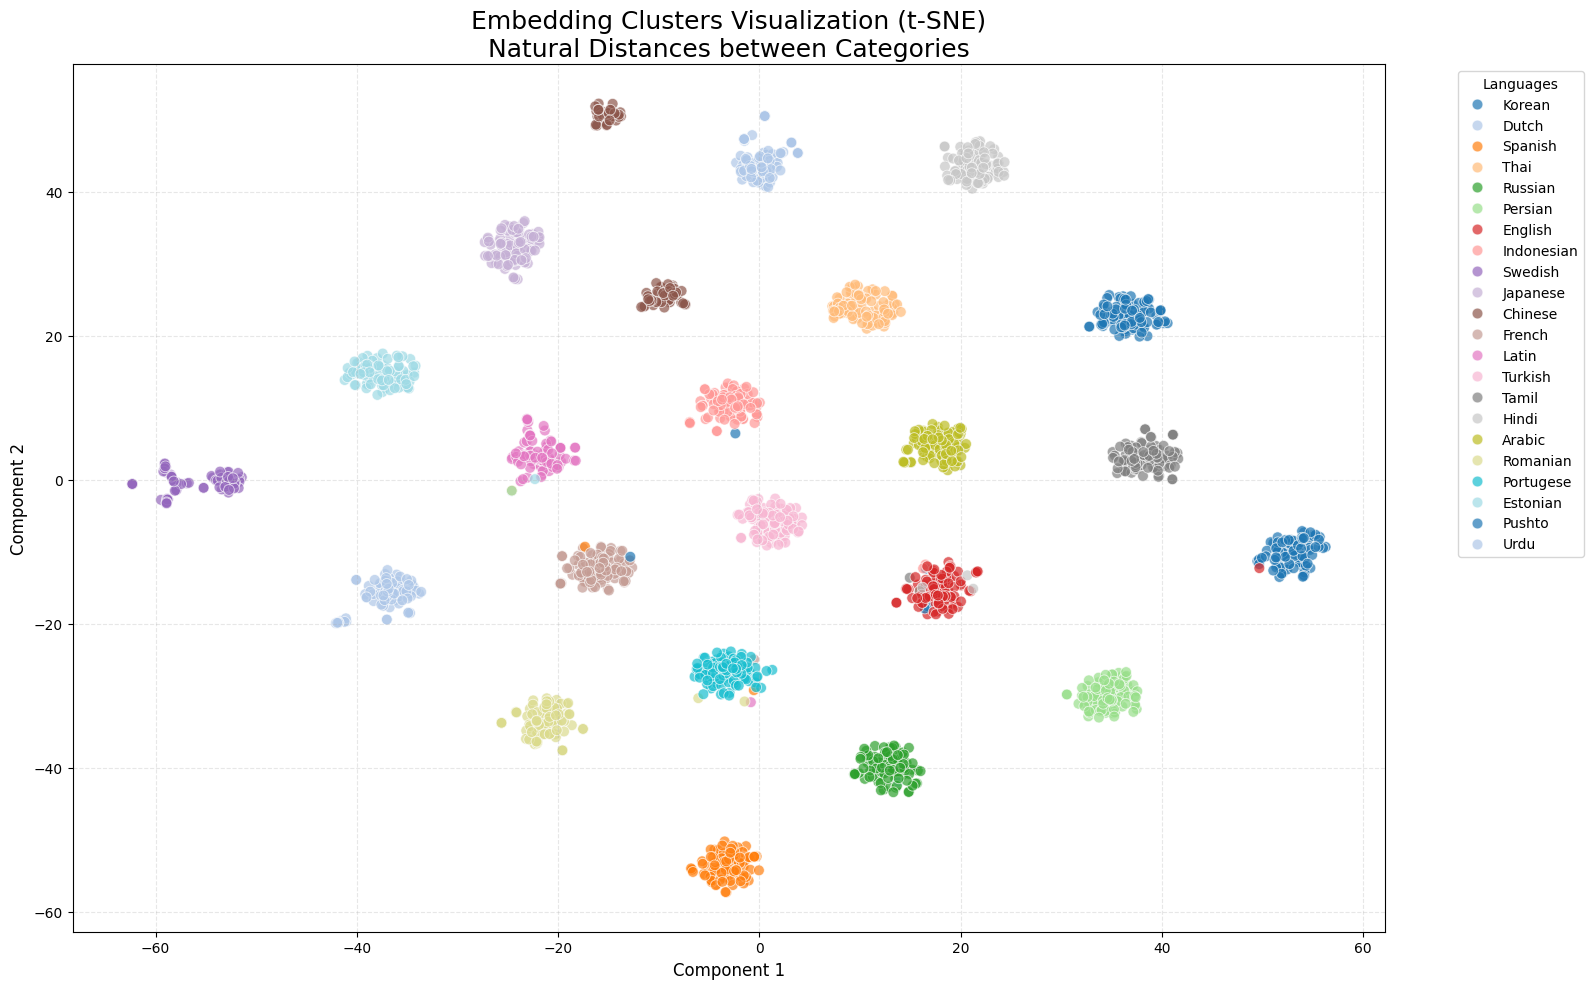

In [18]:
embedding_dataloader = DataLoader(testing_dataset, batch_size=32, shuffle=False, collate_fn=classifier.data_collator)

print("Extracting embeddings from the test set...")
embeddings, labels = get_embeddings(distilbert_model, embedding_dataloader, DEVICE)

print("Applying PCA...")
pca = PCA(n_components=2)
embeddings_pca = pca.fit_transform(embeddings)

print("Applying t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embeddings_tsne = tsne.fit_transform(embeddings)

plot_embeddings(embeddings_pca, labels, "Embedding Clusters Visualization (PCA)\nGeometric Structure of Languages", class_names)

plot_embeddings(embeddings_tsne, labels, "Embedding Clusters Visualization (t-SNE)\nNatural Distances between Categories", class_names)

Extracting logits from the test set...


Extracting logits: 100%|██████████| 69/69 [00:01<00:00, 45.35it/s]


Applying PCA on logits...
Applying t-SNE on logits...
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Language_Space_Visualization_(PCA_on_logits).png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Language_Space_Visualization_(PCA_on_logits).png


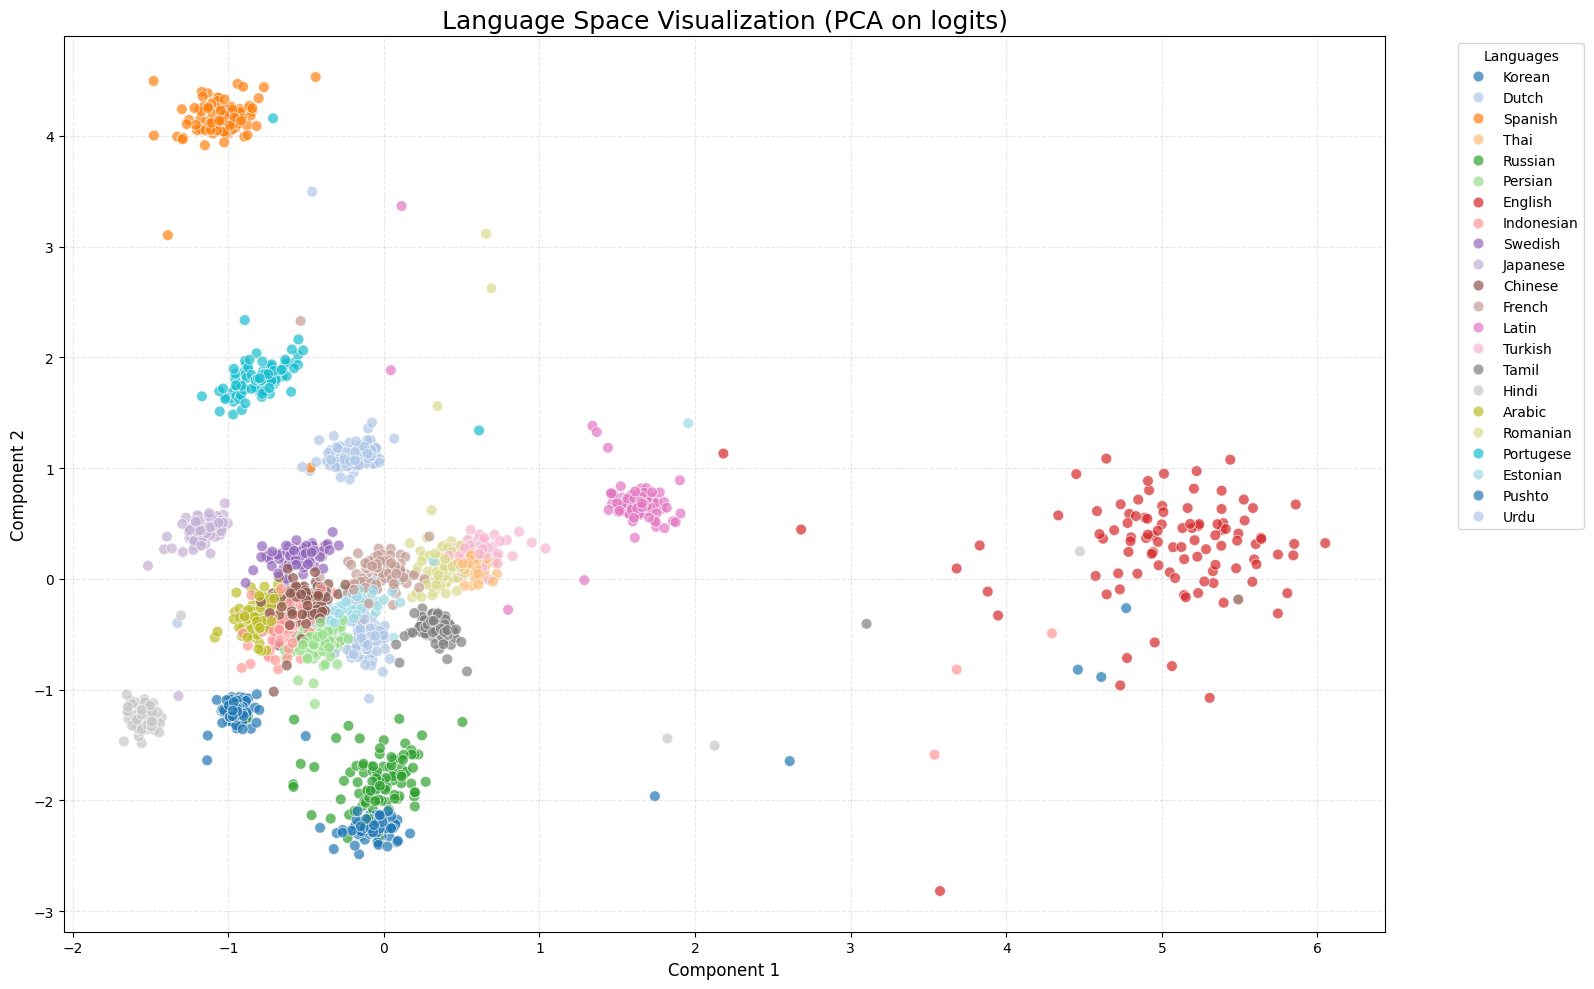

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Language_Space_Visualization_(t-SNE_on_logits).png


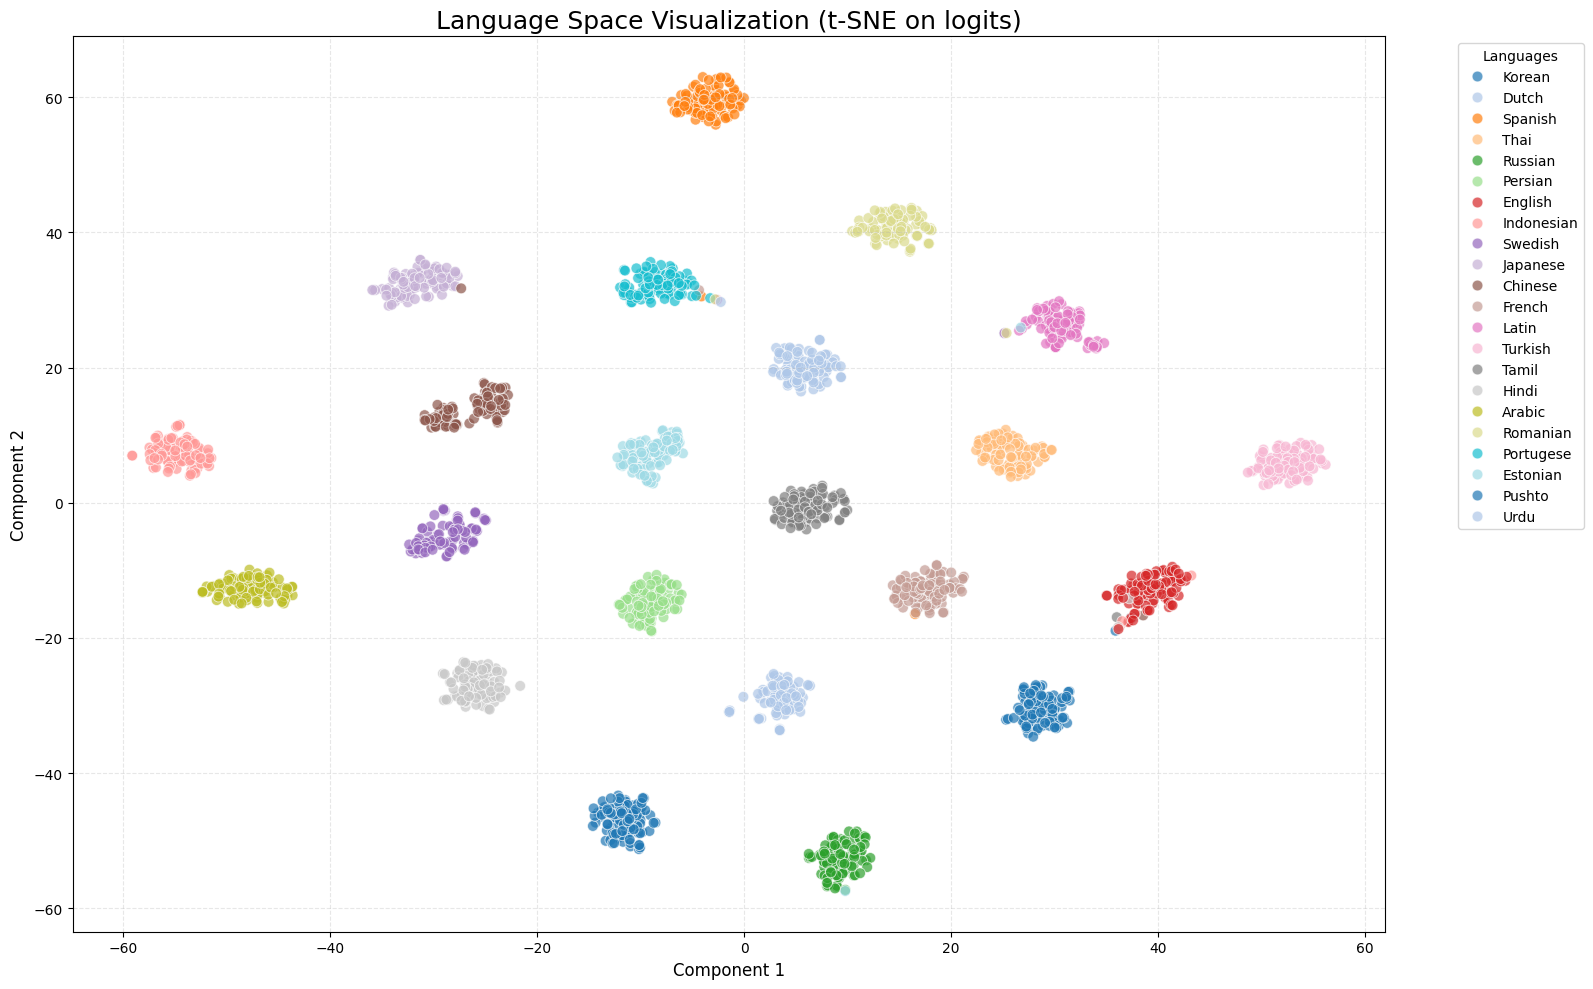

In [19]:
logit_dataloader = DataLoader(
    testing_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=classifier.data_collator
)

print("Extracting logits from the test set...")
logits, labels = get_logits(distilbert_model, logit_dataloader, DEVICE)

print("Applying PCA on logits...")
pca = PCA(n_components=2)
logits_pca = pca.fit_transform(logits)

print("Applying t-SNE on logits...")
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=30,
    n_iter=1000
)
logits_tsne = tsne.fit_transform(logits)

plot_embeddings(
    logits_pca, labels,
    title="Language Space Visualization (PCA on logits)",
    class_names=class_names
)

plot_embeddings(
    logits_tsne, labels,
    title="Language Space Visualization (t-SNE on logits)",
    class_names=class_names
)

# 5. Case Study: Capabilities, Reliability, and Diagnostics

## 5.1 Capabilities & Mechanisms 

### Standard Single-Language Performance & Attribution


In [20]:
# Ensure model is in evaluation mode
distilbert_model.eval()

run_standard_case_study(distilbert_model, distilbert_tokenizer, DEVICE, class_names)

Text                                                         | True       | Pred       | Conf  
-----------------------------------------------------------------------------------------------
The quick brown fox jumps over the lazy dog....              | English    | English    | 0.9068
La vie est belle quand on profite de chaque instant....      | French     | French     | 0.9137
El conocimiento es poder y la educación es la clave....      | Spanish    | Spanish    | 0.8964
今天天气真好，我们去公园散步吧。...                                          | Chinese    | Chinese    | 0.9155
اللغة العربية هي لغة جميلة جداً ولها تاريخ عريق....          | Arabic     | Arabic     | 0.8968
Москва — столица России, красивый и большой город....        | Russian    | Russian    | 0.8780
Das Wetter ist heute sehr schön und die Sonne scheint....    | German     | Portugese  | 0.5422
La vita è bella e bisogna godersela al massimo....           | Italian    | Dutch      | 0.5325
Obrigado por tudo, você foi muito gentil

,Text,True Language,Predicted Language,Confidence
0,The quick brown fox jumps over the lazy dog.,English,English,0.906757
1,La vie est belle quand on profite de chaque in...,French,French,0.913677
2,El conocimiento es poder y la educación es la ...,Spanish,Spanish,0.896432
3,今天天气真好，我们去公园散步吧。,Chinese,Chinese,0.915494
4,اللغة العربية هي لغة جميلة جداً ولها تاريخ عريق.,Arabic,Arabic,0.896808
5,"Москва — столица России, красивый и большой го...",Russian,Russian,0.878039
6,Das Wetter ist heute sehr schön und die Sonne ...,German,Portugese,0.542236
7,La vita è bella e bisogna godersela al massimo.,Italian,Dutch,0.532511
8,"Obrigado por tudo, você foi muito gentil comigo.",Portuguese,Portugese,0.881537
9,"Merhaba dünya, bugün nasılsın?",Turkish,Turkish,0.820865


**Analysis:**


### Attention Visualization (Standard Cases)


Visualizing last-layer DistilBERT attention for Standard/Representative Cases...

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Last-Layer_Attention_from_[CLS]_—_Das_Wetter_ist_heute_sehr_schön_und_die_Sonne_sche....png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Last-Layer_Attention_from_[CLS]_—_Das_Wetter_ist_heute_sehr_schön_und_die_Sonne_sche....png


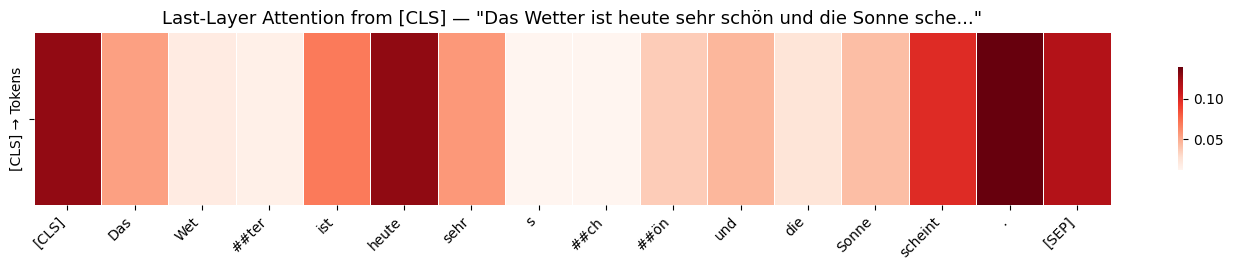

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Last-Layer_Attention_from_[CLS]_—_C'est_la_vie,_mon_ami.....png


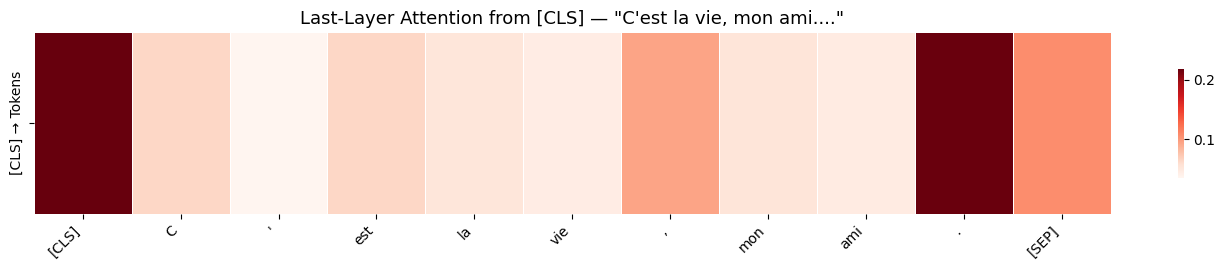

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Last-Layer_Attention_from_[CLS]_—_I_was_working_when_mon_ami_m'a_appelé.....png


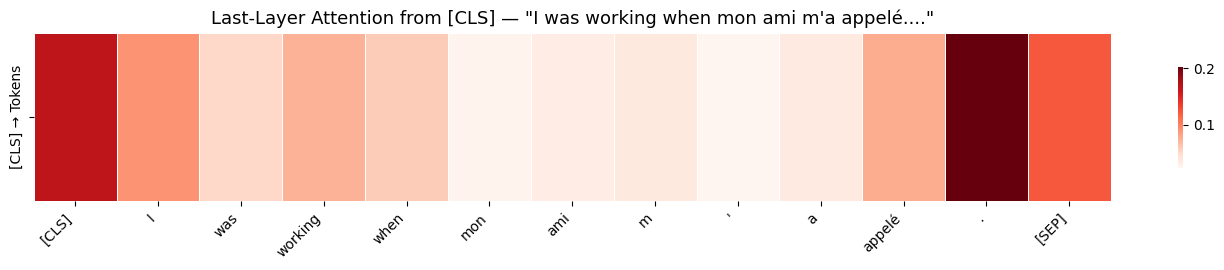

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Last-Layer_Attention_from_[CLS]_—_I_love_learning_new_languages,_especially_اللغة_ال....png


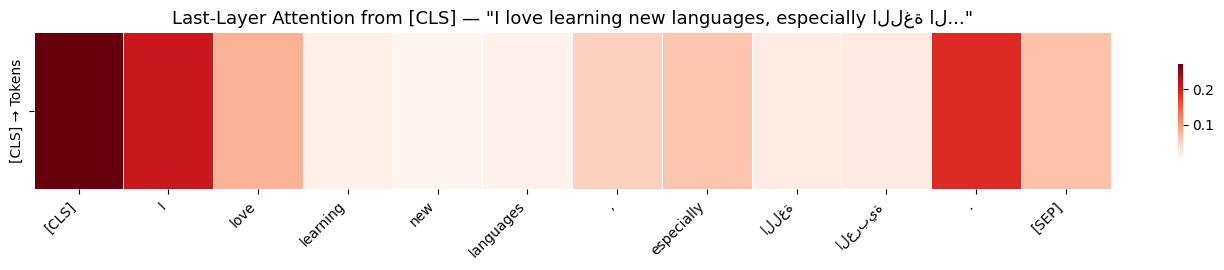

In [21]:
# Representative examples for attention visualization (Standard & Simple Mixed)
cases_for_viz = [
    "Das Wetter ist heute sehr schön und die Sonne scheint.",      # German
    "C'est la vie, mon ami.",                                      # French
    "I was working when mon ami m'a appelé.",                      # English + French
    "I love learning new languages, especially اللغة العربية."      # English + Arabic
]

print("Visualizing last-layer DistilBERT attention for Standard/Representative Cases...\n")

for text in cases_for_viz:
    visualize_attention(
        text=text, 
        model=distilbert_model, 
        tokenizer=distilbert_tokenizer, 
        device=DEVICE
    )

### Advanced Capabilities: Code-Switching Analysis
Here I analyze the model's ability to handle **Code-Switching** (mixed-language sentences) using a Sliding Window approach. This highlights the model's local perception capabilities.

In [22]:
mixed_cases = [
    "I was working on the project when suddenly mon ami m'a appelé pour aller déjeuner.",
    "The weather is nice today, aber es ist ein bisschen kalt draußen.",
    "今天天气真好, so we decided to go for a walk in the park.",
    "El profesor said that the exam will be difficult, pero vamos a estudiar mucho.",
    "I love learning new languages, especially اللغة العربية because it is beautiful."
]

for text in mixed_cases:
    main_lang, segments = analyze_mixed_language_offset(
        text=text,
        tokenizer=distilbert_tokenizer,
        model=distilbert_model,
        class_names=class_names,
        window_size=8,
        stride=3,
        device=DEVICE
    )

    print_analysis(text, main_lang, segments)


INPUT:
I was working on the project when suddenly mon ami m'a appelé pour aller déjeuner.

GLOBAL PREDICTION: English

SEGMENTED ANALYSIS:
I was working on the project when suddenly mon ami m'a appelé pour aller déjeuner . 


INPUT:
The weather is nice today, aber es ist ein bisschen kalt draußen.

GLOBAL PREDICTION: Portugese

SEGMENTED ANALYSIS:
The weather is nice today , aber es ist ein bisschen kalt draußen. 


INPUT:
今天天气真好, so we decided to go for a walk in the park.

GLOBAL PREDICTION: English

SEGMENTED ANALYSIS:
今天天气真好 , so we decided to go for a walk in the park. 


INPUT:
El profesor said that the exam will be difficult, pero vamos a estudiar mucho.

GLOBAL PREDICTION: Spanish

SEGMENTED ANALYSIS:
El profesor said that the exam will be difficult, pero vamos a estudiar mucho. 


INPUT:
I love learning new languages, especially اللغة العربية because it is beautiful.

GLOBAL PREDICTION: English

SEGMENTED ANALYSIS:
I love learning new languages, especially اللغة العربية becau

## 5.2 Reliability & Boundaries 

### Hard Cases Stress Test
I stress-test the model with:
1.  **Very Short Texts:** (1-3 words)
2.  **Closely Related Languages:** (High lexical overlap)
3.  **Noisy Inputs:** (Emojis, code, etc.)

I expect lower confidence scores here.

In [23]:
run_hard_case_study(distilbert_model, distilbert_tokenizer, DEVICE, class_names)

Type                   | Text                           | Expected                       | Pred       | Conf  
--------------------------------------------------------------------------------------------------------------
Short / Ambiguous      | No                             | Spanish/English/Italian...     | Dutch      | 0.2540
Short / Ambiguous      | Chat                           | French (Cat) / English         | French     | 0.2795
Short / False Friend   | Gift                           | English (Gift) / German (Poison) | Dutch      | 0.2331
Similar (Port/Span)    | Eu não sei o que fazer.        | Portuguese                     | Portugese  | 0.8417
Similar (Port/Span)    | No sé qué hacer.               | Spanish                        | Spanish    | 0.8424
Similar (Indo/Malay)   | Selamat pagi dunia.            | Indonesian/Malay               | Indonesian | 0.8592
Emoji Only             | 😂😂😂 🚀🚀🚀                        | Unknown/Noise                  | Thai       | 0.7306

### OOD (Out-of-Domain) & Thresholding
Since the model's confidence drops on hard/unknown cases, I establish a **Confidence Threshold** to reject uncertain predictions.

I compare the confidence distribution of **In-Domain (ID)** validation data vs. **Out-of-Domain (OOD)** noise data.

Predicting on validation set...

Total validation samples: 2200
Correct predictions: 2183 (99.23%)
OOD Threshold (5th percentile of correct confidences): 0.8844

Total validation samples: 2200
Correct predictions: 2183 (99.23%)
OOD Threshold (5th percentile of correct confidences): 0.8844
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Distribution_of_Confidence_Scores_for_Correct_Predictions_(Validation_Set).png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Distribution_of_Confidence_Scores_for_Correct_Predictions_(Validation_Set).png


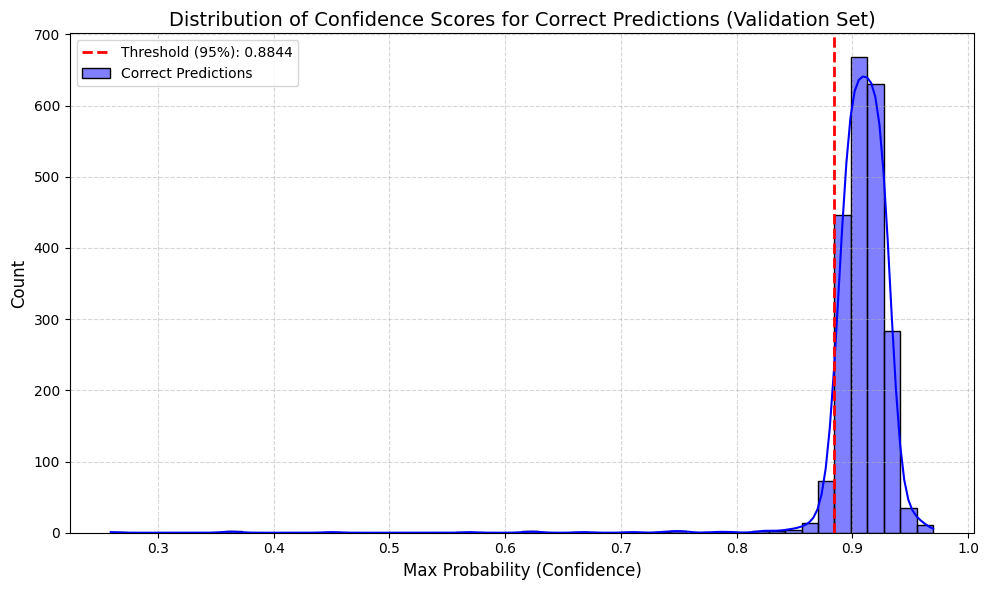

In [24]:
# 1. Get predictions on the validation dataset
print("Predicting on validation set...")
val_output = trainer.predict(validation_dataset)
val_logits = val_output.predictions
val_labels = val_output.label_ids

# 2. Calculate probabilities (Softmax)
val_probs = torch.nn.functional.softmax(torch.tensor(val_logits), dim=1).numpy()

# 3. Get max probability and predicted class
val_max_probs = np.max(val_probs, axis=1)
val_preds = np.argmax(val_probs, axis=1)

# 4. Identify correct predictions
correct_mask = (val_preds == val_labels)
correct_max_probs = val_max_probs[correct_mask]

# 5. Calculate the threshold (5th percentile)
ood_threshold = np.percentile(correct_max_probs, 5)

print(f"\nTotal validation samples: {len(val_labels)}")
print(f"Correct predictions: {len(correct_max_probs)} ({len(correct_max_probs)/len(val_labels):.2%})")
print(f"OOD Threshold (5th percentile of correct confidences): {ood_threshold:.4f}")

# 6. Visualization
plt.figure(figsize=(10, 6))
sns.histplot(correct_max_probs, bins=50, kde=True, color='blue', label='Correct Predictions')
plt.axvline(ood_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold (95%): {ood_threshold:.4f}')
plt.title("Distribution of Confidence Scores for Correct Predictions (Validation Set)", fontsize=14)
plt.xlabel("Max Probability (Confidence)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

OOD sample nums: 140


,type,text
0,noise,odJFCrn](l.2edlBD#
1,noise,d*z|@`(1C5.Jau`2R
2,noise,tBRnlWmTS:Hf
3,noise,"6'pWk)L=<U,y{if[DLk"
4,noise,mWJ6>UuVTA\


Processing ID (Validation) Data...
Processing OOD Data...


/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



ID Samples: 2200
OOD Samples: 140
Avg ID Confidence: 0.9060
Avg OOD Confidence: 0.4690
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Confidence_Distribution_In-Distribution_vs_Out-of-Distribution.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Confidence_Distribution_In-Distribution_vs_Out-of-Distribution.png


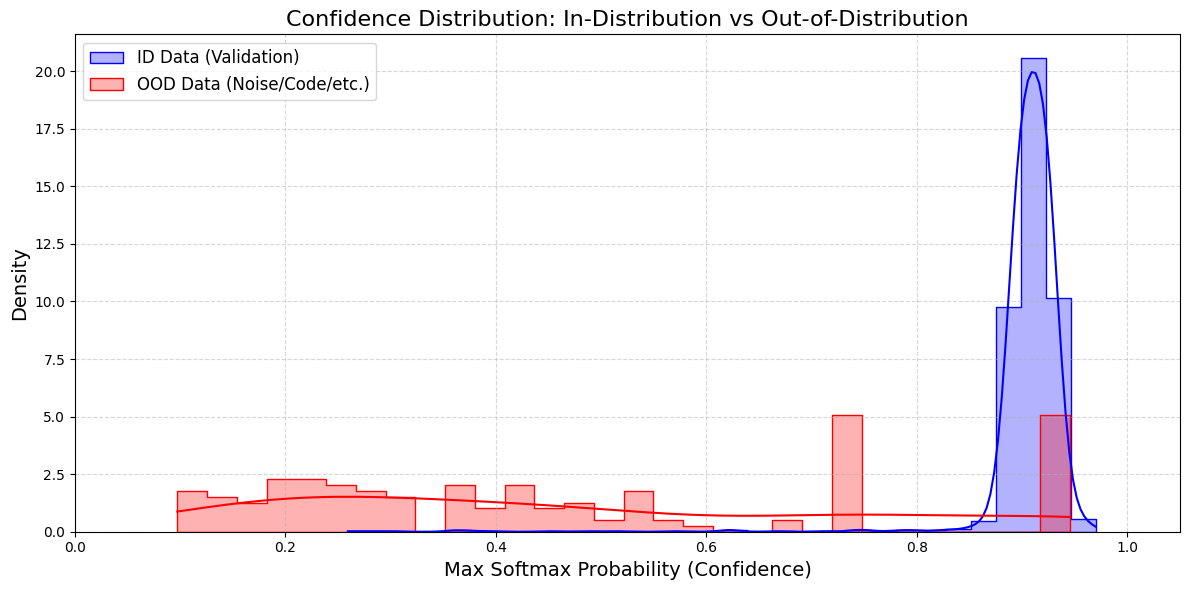

Optimal Threshold (Youden's J): 0.7441
Max J Statistic: 0.8485
ROC AUC: 0.8566
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Receiver_Operating_Characteristic_(ROC).png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Receiver_Operating_Characteristic_(ROC).png


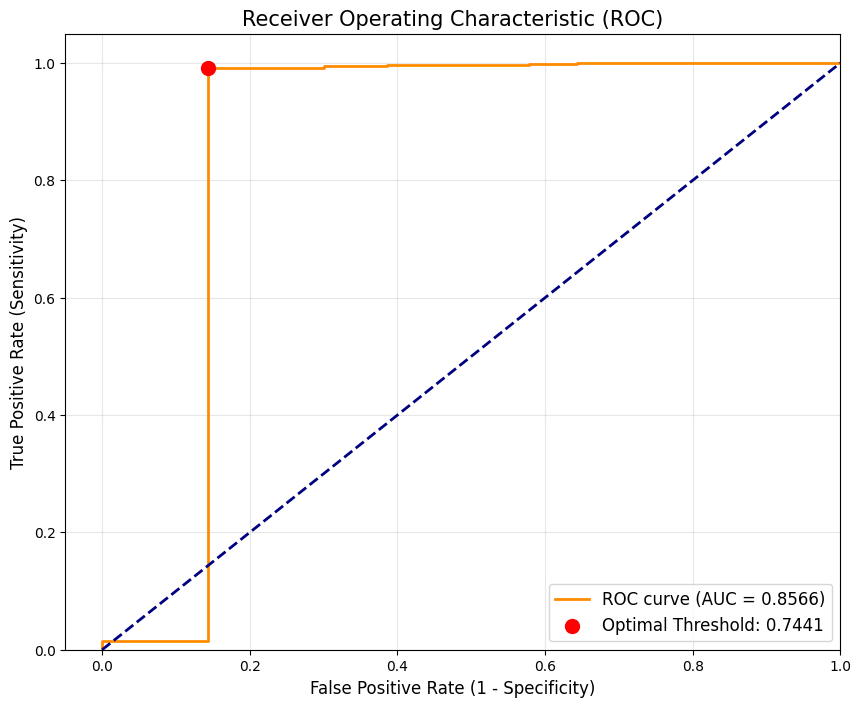

--------------------------------------------------
Performance at Threshold 0.7441:
ID Data Accepted (TPR): 99.14%
OOD Data Rejected (TNR): 85.71%
--------------------------------------------------


In [25]:
# ====================================================
# 1. Generate OOD Data
# ====================================================
ood_df = create_ood_dataset_df(n_samples=20)
print(f"OOD sample nums: {len(ood_df)}")
display(ood_df.head())

# ====================================================
# 2. Distribution Analysis: Get Confidence Scores
# ====================================================

# --- A. ID Data (Validation Set) ---
print("Processing ID (Validation) Data...")
# (Already calculated in previous cell as val_probs, but let's re-use or re-calc if needed for clarity)
id_confidences = np.max(val_probs, axis=1)

# --- B. OOD Data (Constructed Noise/Out-of-Domain) ---
print("Processing OOD Data...")
ood_texts = ood_df['text'].apply(clean_text).tolist()

try:
    encoding_len = max_length
except NameError:
    encoding_len = 128

ood_encodings = distilbert_tokenizer(
    ood_texts,
    truncation=True,
    padding=True,
    max_length=encoding_len
)

ood_labels = [0] * len(ood_texts) 
ood_dataset = LanguageDataset(ood_encodings, ood_labels)

ood_output = trainer.predict(ood_dataset)
ood_probs = torch.nn.functional.softmax(torch.tensor(ood_output.predictions), dim=1).numpy()
ood_confidences = np.max(ood_probs, axis=1)

print(f"\nID Samples: {len(id_confidences)}")
print(f"OOD Samples: {len(ood_confidences)}")
print(f"Avg ID Confidence: {np.mean(id_confidences):.4f}")
print(f"Avg OOD Confidence: {np.mean(ood_confidences):.4f}")

# Visualization
plot_confidence_distribution(id_confidences, ood_confidences)

# ====================================================
# 3. Threshold Selection: ROC + Youden's J
# ====================================================
metrics = calculate_ood_metrics(id_confidences, ood_confidences)

print(f"Optimal Threshold (Youden's J): {metrics['best_threshold']:.4f}")
print(f"Max J Statistic: {metrics['best_j']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")

# Plot ROC Curve
plot_roc_curve(metrics['fpr'], metrics['tpr'], metrics['roc_auc'], metrics['best_threshold'], metrics['best_idx'])

print("-" * 50)
print(f"Performance at Threshold {metrics['best_threshold']:.4f}:")
print(f"ID Data Accepted (TPR): {metrics['id_acc']:.2%}")
print(f"OOD Data Rejected (TNR): {metrics['ood_rej_rate']:.2%}")
print("-" * 50)

## 5.3 Error Diagnostics

### Macro Analysis: Top Confused Pairs
First, I identify which language pairs are most frequently confused (e.g., Spanish vs. Portuguese). This often points to linguistic similarity.

In [26]:
# Calculate and display top confused pairs
df_confused_sorted = get_confused_pairs(cm, class_names)

print("Top 10 Most Confused Language Pairs (by Count):")
display(df_confused_sorted.head(10).style.format({'Percentage': '{:.2%}'}))

Top 10 Most Confused Language Pairs (by Count):


,True Language,Predicted Language,Count,Percentage
150,Indonesian,English,3,3.00%
276,Pushto,English,3,3.00%
23,Chinese,English,1,1.00%
98,Estonian,Russian,1,1.00%
138,Hindi,Pushto,1,1.00%
28,Chinese,Japanese,1,1.00%
75,English,Pushto,1,1.00%
221,Latin,Portugese,1,1.00%
262,Portugese,Latin,1,1.00%
306,Romanian,Portugese,1,1.00%


### Micro Analysis: Error Cases Table
I list specific misclassified examples from the test set to see the exact text causing issues.

In [27]:
error_df, selected_indices = get_error_cases(preds, testing_labels, testing_texts, class_names, logits)
if error_df is not None:
    display(error_df)

,Text (Truncated),True,Pred,Max Prob
0,julius krohn «die entstehung der einheitlichen...,Estonian,Russian,0.5623
1,at weddings he was acclaimed for the warm welc...,Pushto,English,0.8596
2,in the us established a central intelligence a...,Hindi,English,0.9074
3,in nasrat parsa was invited to perform at a co...,Pushto,English,0.9003
4,lance a durdfn and guy g musser the sucking li...,Romanian,Latin,0.4141
5,senapan × fixed forward-firing mm in type mach...,Indonesian,English,0.3510
6,上社村、宋家庄村、佛堂村、胡家庄村、中庄村、上庄村、刘家庄村、白藏村、下北村、下鹤山南村、上...,Chinese,Japanese,0.1339
7,dorf matthew after barak win aipac reverses op...,Chinese,English,0.9281
8,o partido federalista do rio grande do sul - c...,Spanish,Portugese,0.5918
9,"""aim to provide easy access to those net resou...",Indonesian,English,0.6760


### Root Cause Analysis: Attention Visualization
Finally, I visualize the attention maps for:
1.  **Specific Error Cases:** To see if the model focused on misleading tokens.
2.  **Top Confused Pairs:** To understand the systematic confusion between similar languages.


Example Index: 1917
Text: 上社村、宋家庄村、佛堂村、胡家庄村、中庄村、上庄村、刘家庄村、白藏村、下北村、下鹤山南村、上鹤山村、大水头村、秋林村、车箱村、西湾村、张城堡村、柳沟村、中南村、中北村、大西外村、大西里村、黄沙口村、回岭只村、青崖只村、窄门只村、肖家汇村、柴庄村、北教场村、磨盘村、刘家沟村、店上村、赵家沟村、邀童来村、外独头村、里独头村、魏家沟村、芦芽沟村、上石塘村、下石塘村、熊坪村、榆林坪村、小峪村、北木口村、榆林子村、北大峪村、南北河村和车轮村。
True Label: Chinese | Predicted: Japanese (Prob: 0.1338)


/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.draw()
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 31038 (\N{CJK UNIFIED IDEOGRAPH-793E}) missing from current font.
  fig.canvas.draw()
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 26449 (\N{CJK UNIFIED IDEOGRAPH-6751}) missing from current font.
  fig.canvas.draw()
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  fig.canvas.draw()
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 23435 (\N{CJK UNIFIED IDEOGRAPH-5B8B}) missing from current font.
  fig.canvas.draw()
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/seaborn/utils.py:61: User

Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Chinese_-_Pred_Japanese.png


/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37324 (\N{CJK UNIFIED IDEOGRAPH-91CC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27801 (\N{CJK UNIFIED IDEOGRAPH-6C99}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 21475 (\N{CJK UNIFIED IDEOGRAPH-53E3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/zyk/anaconda3/envs/mrag/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22238 (\N{CJK UNIF

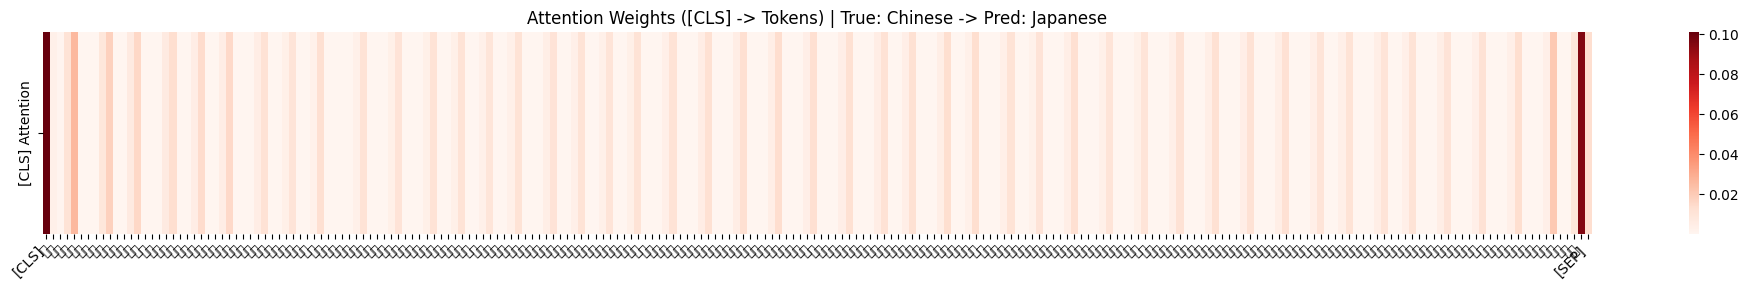


Example Index: 36
Text: o partido federalista do rio grande do sul - cadernos de história memorial do rio grande do sul nº sérgio da costa franco en portugués pdf
True Label: Spanish | Predicted: Portugese (Prob: 0.5918)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Spanish_-_Pred_Portugese.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Spanish_-_Pred_Portugese.png


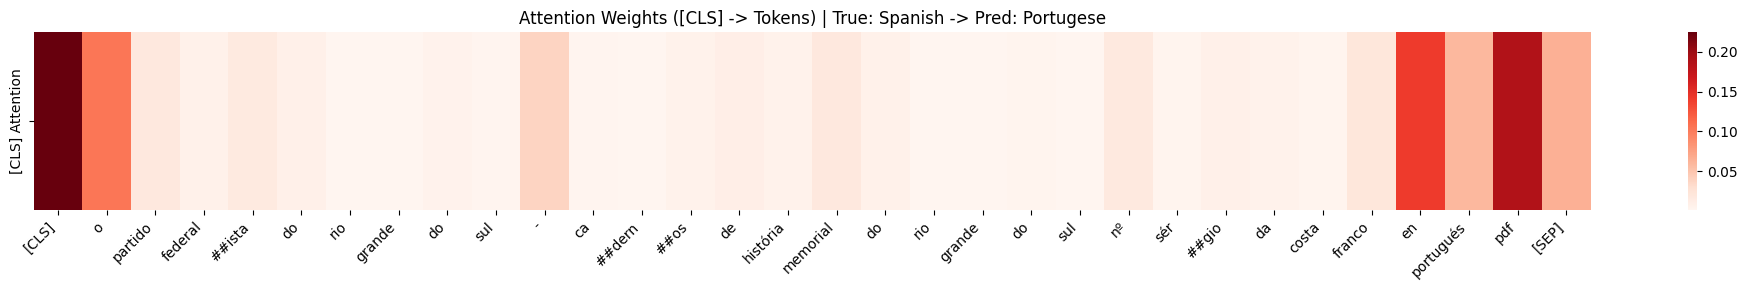


Example Index: 1746
Text: marcus gavius apicius ekr- pkr de re coquinaria cookery and dining in imperial rome vehling joseph dommers – [translator] starr frederick – [commentator] []
True Label: Estonian | Predicted: Latin (Prob: 0.7954)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Estonian_-_Pred_Latin.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Estonian_-_Pred_Latin.png


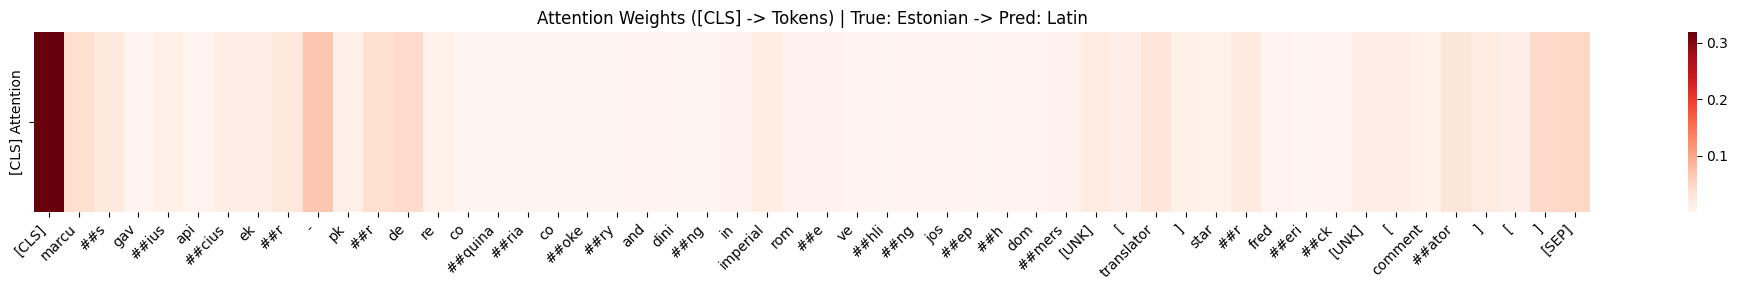


Example Index: 649
Text: lacordaire t histoire naturelle des insectes genera des coléoptères ou exposé méthodique et critique de tous les genres proposés jusquici dans cet ordre dinsectes vol roret paris pp
True Label: Spanish | Predicted: French (Prob: 0.7256)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Spanish_-_Pred_French.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Spanish_-_Pred_French.png


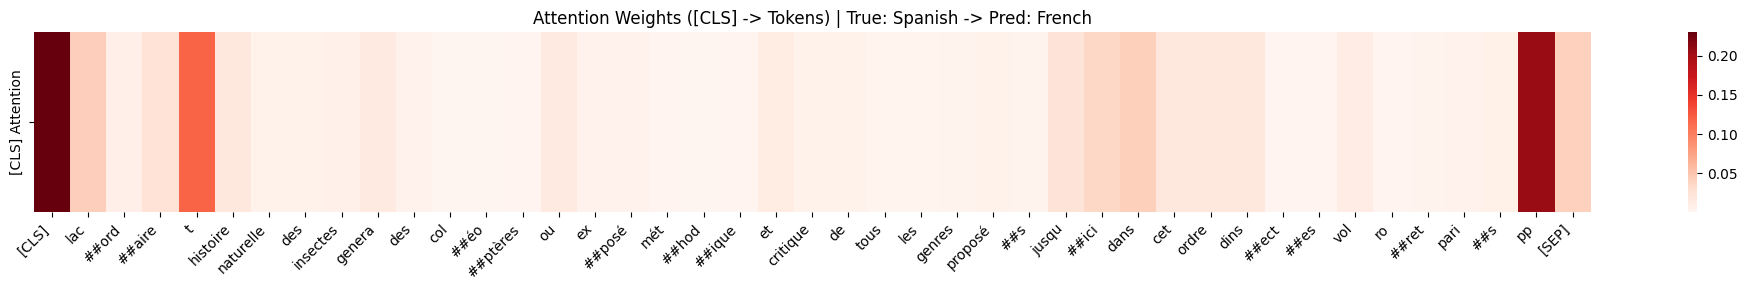


Example Index: 509
Text: szakolczai a liminality and experience structuring transitory situations and transformative events international political anthropology -
True Label: Latin | Predicted: Portugese (Prob: 0.1660)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Latin_-_Pred_Portugese.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Latin_-_Pred_Portugese.png


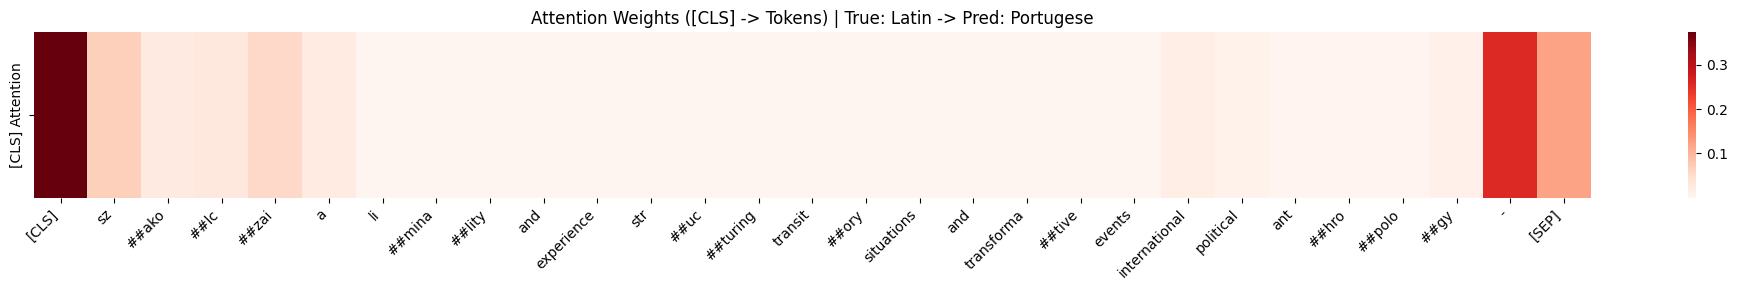


Example Index: 2044
Text: sayyid yusuf hashim al-rifa’i nasiha li-ikhwaninia ulama’ najd “advice to our brethren the scholars of najd” introduction by msr al-buti with sayyid ‘alawi ahmad al-haddad’s misbah al-anam “the light of mankind” english
True Label: English | Predicted: Pushto (Prob: 0.7598)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_English_-_Pred_Pushto.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_English_-_Pred_Pushto.png


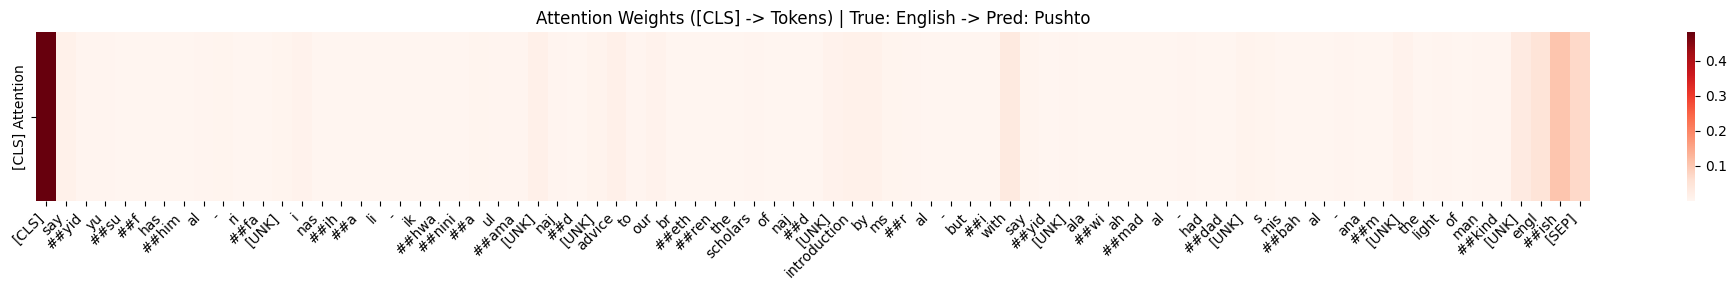

In [28]:
# 1. Visualize Attention for Specific Error Cases
# Indices of the examples to visualize (based on the Error Case Study table above)
examples_to_viz_indices = [6, 8, 10, 12, 14, 19]

# Ensure we have the original indices from the previous step
if 'selected_indices' in locals():
    # Get the original indices in the testing dataset
    valid_indices = [i for i in examples_to_viz_indices if i < len(selected_indices)]
    viz_indices = selected_indices[valid_indices]
else:
    print("Variable 'selected_indices' not found. Please run the Error Case Study cell first.")
    viz_indices = []

# Run visualization using the imported function
if len(viz_indices) > 0:
    for idx in viz_indices:
        visualize_bert_attention(
            idx, 
            distilbert_model, 
            distilbert_tokenizer, 
            DEVICE,
            testing_texts,
            testing_labels,
            class_names
        )
else:
    print("No indices to visualize.")

Visualizing attention for the top 2 confused pairs:

##################################################
Pair: True 'Indonesian' -> Predicted 'English' (Total Count: 3)
##################################################

--- Example 1/3 (Index: 414) ---

Example Index: 414
Text: "aim to provide easy access to those net resources pertaining to the life and work of the th century philosopher edmund husserl"
True Label: Indonesian | Predicted: English (Prob: 0.6760)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Indonesian_-_Pred_English.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Indonesian_-_Pred_English.png


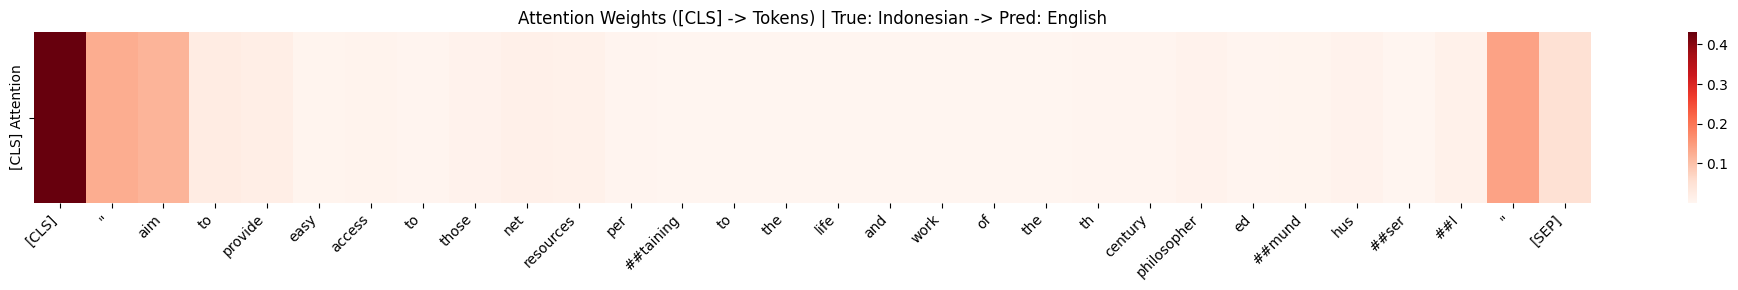


--- Example 2/3 (Index: 580) ---

Example Index: 580
Text: senapan × fixed forward-firing mm in type machine gun and × flexible rearward-firing mm in type machine gun
True Label: Indonesian | Predicted: English (Prob: 0.3513)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Indonesian_-_Pred_English.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Indonesian_-_Pred_English.png


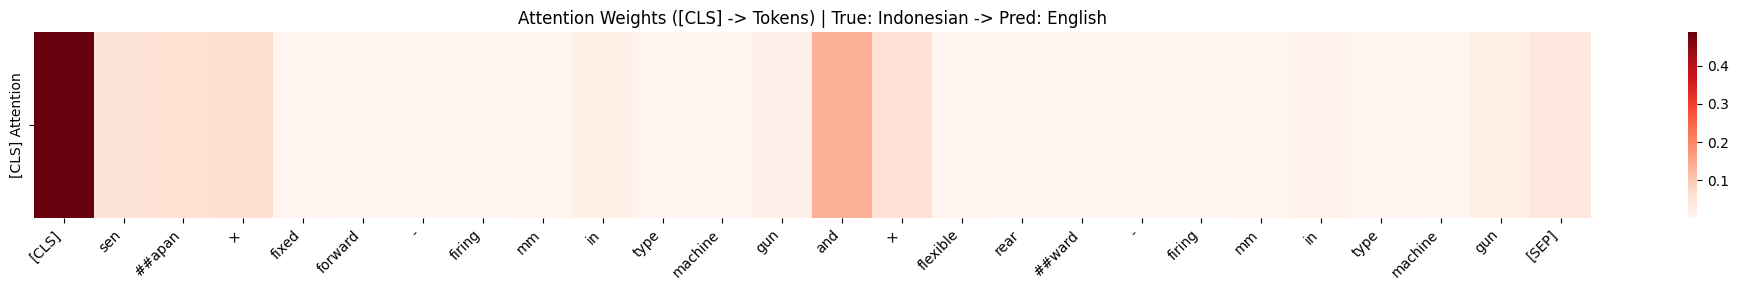


--- Example 3/3 (Index: 1227) ---

Example Index: 1227
Text: prisoners of war name list a large amount of information regarding the fate of australian and british prisoners sent to or destined for the sandakan pow camp has been collated
True Label: Indonesian | Predicted: English (Prob: 0.7129)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Indonesian_-_Pred_English.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Indonesian_-_Pred_English.png


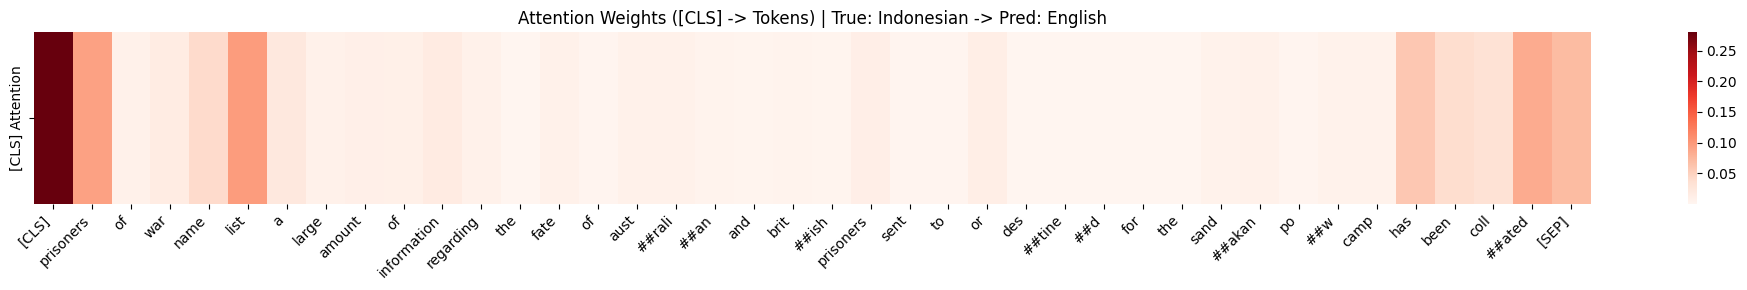


##################################################
Pair: True 'Pushto' -> Predicted 'English' (Total Count: 3)
##################################################

--- Example 1/3 (Index: 110) ---

Example Index: 110
Text: a compromise between the two has a small cadre of professional ncos non-commissioned officers and officers who act as a skeleton for a much larger force when war comes this skeleton is filled out with conscripts or reservists former full-time soldiers who volunteer for a small stipend to occasionally train with the cadre to keep their military skills intact who form the wartime unit this balances the pros and cons of each basic organization and allows the formation of huge armies in terms of millions of combatants necessary in modern large scale warfare
True Label: Pushto | Predicted: English (Prob: 0.8750)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Pushto_-_Pred_English.png
Saved figure to /h

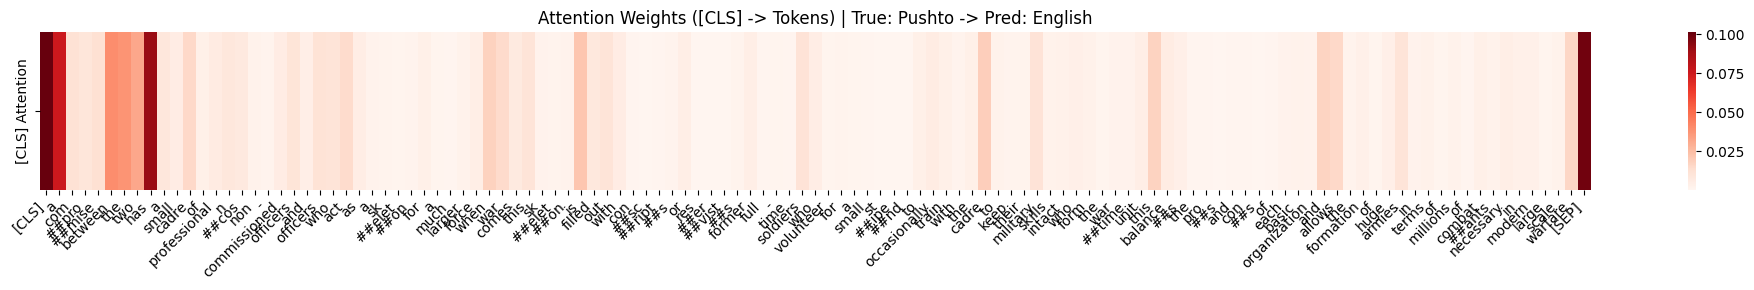


--- Example 2/3 (Index: 559) ---

Example Index: 559
Text: in nasrat parsa was invited to perform at a concert in vancouver on the occasion of mother’s day opening a comprehensive tour that was scheduled to include several cities in north america at the height of his popularity and on the occasion of promoting his upcoming album dil the singer flew to canada where he performed to a large crowd of fans some of whom saw him live on stage for the first time
True Label: Pushto | Predicted: English (Prob: 0.9006)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Pushto_-_Pred_English.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Pushto_-_Pred_English.png


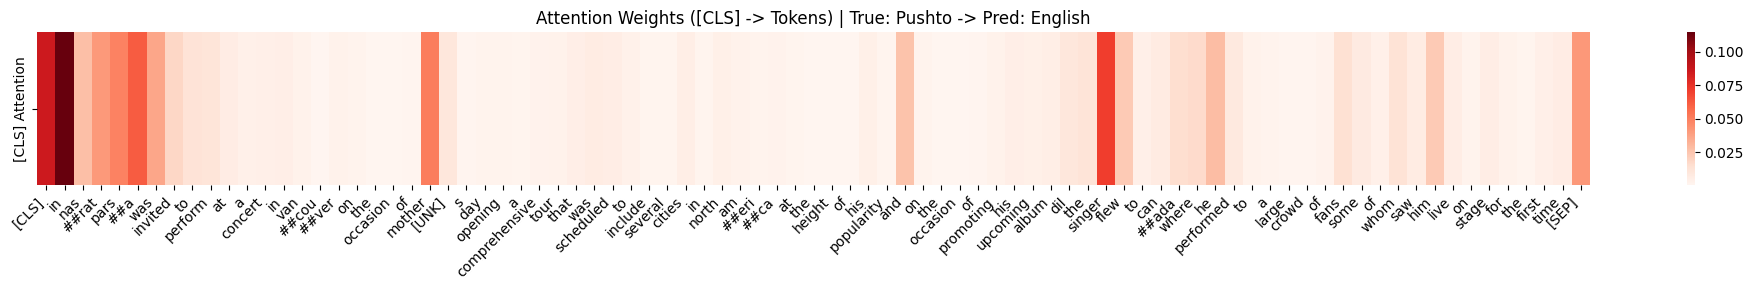


--- Example 3/3 (Index: 615) ---

Example Index: 615
Text: at weddings he was acclaimed for the warm welcoming of the bride and groom with his number maa destmal aawordaim ما دستمال آورديم gohar album which roughly translates as “we‘ve brought our brother’s bride” this album established nasrat as a respected singer and also garnered him praise of critics as a matter of fact the monumentalizing of the bride and groom union following the entrance anthem of ahesta boro آهسته برو in weddings with the hit song of the gohar album is now a strong tradition of afghan weddings
True Label: Pushto | Predicted: English (Prob: 0.8595)
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Pushto_-_Pred_English.png
Saved figure to /home/zyk/Language Identification/outputs/figures/distilbert/Attention_Weights_([CLS]_-_Tokens)__True_Pushto_-_Pred_English.png


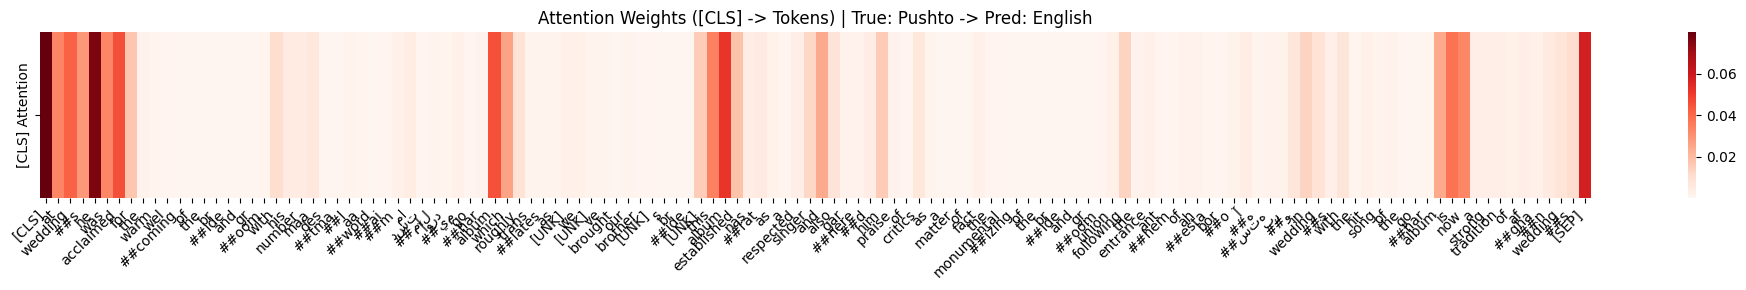

In [29]:
# 2. Visualize Attention for Top Confused Pairs
visualize_top_confused_pairs(
    df_confused_sorted, 
    distilbert_model, 
    distilbert_tokenizer, 
    DEVICE, 
    testing_labels, 
    preds, 
    class_names, 
    testing_texts, 
    top_k=2
)